# Project: Wrangle and Analyze WeRateDogs twitter data

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tweepy

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from IPython.display import HTML, display


## Gather Data

In [4]:
# Read the csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
# Download the tsv file using the Requests library and the given URL
url =' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open('image-predictions.tsv', 'wb') as f:
        f.write(r.content)
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##### Fetching Data from the Twitter API
Since it is a long process I put this code into a separate python file called: `fetch_twitter_data.py`

Set-up tweepy API with the required keys. Fetch each tweet one by one and write into a file called `tweet_json.txt`

In [6]:

'''
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\n# Query the Twitter API for each tweet\'s JSON data using Python\'s Tweepy library and store each tweet\'s entire set of \n# JSON data in a file called tweet_json.txt file\n\nconsumer_key = \'X\'\nconsumer_secret = \'X\'\naccess_token = \'X\'\naccess_secret = \'X\'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\napi = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)\n\nwith open(\'tweet_json.txt\', \'a\', encoding=\'utf8\') as f:\n    for tweet_id in df_twitter_archive[\'tweet_id\']:\n        try:\n            tweet = api.get_status(tweet_id)\n            json.dump(tweet._json, f)\n            f.write(\'\n\')\n        except:\n            print("Error on tweet: " + str(tweet_id))\n            continue\n\n'

In [7]:
# Create a dataframe with tweet ID, retweet count, and favorite count
df_list = []
with open('tweet_json.txt') as file:
    for line in file:
        tweet = json.loads(line)
        
        df_list.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
       
df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551


## Assess Data

In [8]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [9]:
df_twitter_archive[df_twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [10]:
df_twitter_archive[df_twitter_archive.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [11]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [13]:
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [14]:
df_twitter_archive.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2356, dtype: object

In [15]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [16]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8315,38014
1,892177421306343426,6142,32641
2,891815181378084864,4067,24565
3,891689557279858688,8450,41365
4,891327558926688256,9157,39551
...,...,...,...
2334,666049248165822465,41,106
2335,666044226329800704,139,292
2336,666033412701032449,43,123
2337,666029285002620928,47,126


In [18]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2339 non-null   int64
 1   retweet_count   2339 non-null   int64
 2   favorite_count  2339 non-null   int64
dtypes: int64(3)
memory usage: 54.9 KB


### Quality 
#### `df_twitter_archive` table
- 181 Retweets
- Missing data in expanded_urls (Tweets without images)
- Not all images are dog images
- The ratings aren't all correct
- Incorrect dog names (a, an, the, etc.)
- Missing values in dog names (represented as None)
- Erroneous datatype (tweet_id, timestamp)
- Hard to understand the source from source column
- Dog stage's type to categorical

#### `df_image_predictions` table
- Missing records (2075 instead of 2356, some of them are probably the retweets, replies or tweets with no images)
- Image predictions that are not dog breed
- Lowercase breed names in p1, p2, p3 and '_' is used instead of space.




### Tidiness
- Merge three data frames.
- Drop unneeded columns.
- Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.
- Combine rating_numerator and rating_denominator columns into one column.


## Clean Data

In [19]:
# Create the copies of the dataframes which will be cleaned
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_tweet_clean = df_tweet.copy()

#### Remove Retweets

##### Define

Remove 181 columns which are retweets and detected by the columns: *retweeted_status_id*, *retweeted_status_user_id* and *retweeted_status_timestamp*. Remove retweets by keeping the null rows of *retweeted_status_id* column.

##### Code

In [20]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

##### Test

In [21]:
 df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

#### Missing data in expanded_urls

##### Define

Remove the tweets without expanded_urls i.e images by keeping the non null data in the *expanded_urls* column.

##### Code

In [22]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.expanded_urls.notnull()]

##### Test

In [23]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

Note: By cleaning the tweets without expanded_urls, we also drop some of the replies.

#### Merge three data frames

##### Define

Merge the `df_tweet_clean` and `df_image_predictions` tables to the `df_twitter_archive_clean` table, both joining on *tweet_id*.

##### Code

In [24]:
# First, merge df_tweet_clean table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_tweet_clean, 
                                    on = ['tweet_id'], how = 'left')

In [25]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

In [26]:
# Second, merge df_image_predictions table to the df_twitter_archive_clean
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_predictions, 
                                    on = ['tweet_id'], how = 'left')

##### Test

In [27]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2117 entries, 0 to 2116
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2117 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2117 non-null   object 
 4   source                      2117 non-null   object 
 5   text                        2117 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2117 non-null   int64  
 11  rating_denominator          2117 non-null   int64  
 12  name                        2117 non-null   object 
 13  doggo                       2117 

**After merging the data frames, keep the tweets with images.**

In [28]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.jpg_url.notnull()]


In [29]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2116
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1994 non-null   object 
 4   source                      1994 non-null   object 
 5   text                        1994 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1994 non-null   object 
 10  rating_numerator            1994 non-null   int64  
 11  rating_denominator          1994 non-null   int64  
 12  name                        1994 non-null   object 
 13  doggo                       1994 

**Drop the tweets with no retweet_count**

In [30]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweet_count.notnull()]

In [31]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1991 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1991 non-null   object 
 4   source                      1991 non-null   object 
 5   text                        1991 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1991 non-null   object 
 10  rating_numerator            1991 non-null   int64  
 11  rating_denominator          1991 non-null   int64  
 12  name                        1991 non-null   object 
 13  doggo                       1991 

#### Drop unneeded columns

##### Define

Drop the the columns related to the retweets and the replies: *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *in_reply_to_status_id*, *in_reply_to_user_id.*

##### Code

In [32]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['retweeted_status_id','retweeted_status_user_id',
                              'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

##### Test

In [33]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1991 non-null   int64  
 1   timestamp           1991 non-null   object 
 2   source              1991 non-null   object 
 3   text                1991 non-null   object 
 4   expanded_urls       1991 non-null   object 
 5   rating_numerator    1991 non-null   int64  
 6   rating_denominator  1991 non-null   int64  
 7   name                1991 non-null   object 
 8   doggo               1991 non-null   object 
 9   floofer             1991 non-null   object 
 10  pupper              1991 non-null   object 
 11  puppo               1991 non-null   object 
 12  retweet_count       1991 non-null   float64
 13  favorite_count      1991 non-null   float64
 14  jpg_url             1991 non-null   object 
 15  img_num             1991 non-null   float64
 16  p1    

#### Combine dog "stage" columns (i.e. doggo, floofer, pupper, and puppo) into one column.


##### Define

Create a new column named *dog_stage*. Extract doggo, floofer, pupper and puppo from the *text* column using pandas' `str.extact method` and place them into the *dog_stage* column. Fill the null values with None.

In [34]:
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains('floofer')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
42,883360690899218434,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,...,1.0,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True
453,800388270626521089,2016-11-20 17:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,None,floofer,...,2.0,golden_retriever,0.359860,True,Pembroke,0.194207,True,collie,0.154603,True
595,776218204058357768,2016-09-15 00:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,...,1.0,Samoyed,0.940326,True,Pomeranian,0.055527,True,keeshond,0.002226,True


There are only 3 tweets with floofer. In the Dogtionary it is stated as 'floof' so I will take into account this.

In [35]:
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains('floof')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
24,887101392804085760,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,...,1.0,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True
42,883360690899218434,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,...,1.0,chow,0.987997,True,Tibetan_mastiff,0.007099,True,Newfoundland,0.002140,True
49,881906580714921986,2017-07-03 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rey. He's a Benebop Cumberfloof. 12/10...,https://twitter.com/dog_rates/status/881906580...,12,10,Rey,None,None,...,1.0,Weimaraner,0.291539,True,Chesapeake_Bay_retriever,0.278966,True,koala,0.127017,False
341,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,...,2.0,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
453,800388270626521089,2016-11-20 17:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,None,floofer,...,2.0,golden_retriever,0.359860,True,Pembroke,0.194207,True,collie,0.154603,True
473,796080075804475393,2016-11-08 20:00:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Yogi. He's 98% floof. Snuggable af. 12...,https://twitter.com/dog_rates/status/796080075...,12,10,Yogi,None,None,...,1.0,chow,0.973846,True,Tibetan_mastiff,0.014110,True,gibbon,0.002358,False
479,794332329137291264,2016-11-04 00:15:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Nimbus (like the cloud). He just bough...,https://twitter.com/dog_rates/status/794332329...,12,10,Nimbus,None,None,...,1.0,Samoyed,0.988307,True,malamute,0.004906,True,Great_Pyrenees,0.002901,True
571,780543529827336192,2016-09-26 23:04:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a perturbed super floof. 12/10 would sn...,https://twitter.com/dog_rates/status/780543529...,12,10,None,None,None,...,1.0,golden_retriever,0.628312,True,Labrador_retriever,0.317365,True,Tibetan_mastiff,0.012260,True
595,776218204058357768,2016-09-15 00:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,...,1.0,Samoyed,0.940326,True,Pomeranian,0.055527,True,keeshond,0.002226,True
609,773922284943896577,2016-09-08 16:33:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Heinrich (pronounced ""Pat""). He's a Bo...",https://twitter.com/dog_rates/status/773922284...,12,10,Heinrich,None,None,...,1.0,Pomeranian,0.554331,True,Samoyed,0.432158,True,chow,0.003199,True


Now there are 22 tweets with 'floof'

##### Code

In [36]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['text'].str.extract('(doggo|floof|pupper|puppo)',
                                                                             expand=True)
df_twitter_archive_clean = df_twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)
df_twitter_archive_clean['dog_stage'].fillna('None', inplace=True)

##### Test

In [37]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 2116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1991 non-null   int64  
 1   timestamp           1991 non-null   object 
 2   source              1991 non-null   object 
 3   text                1991 non-null   object 
 4   expanded_urls       1991 non-null   object 
 5   rating_numerator    1991 non-null   int64  
 6   rating_denominator  1991 non-null   int64  
 7   name                1991 non-null   object 
 8   retweet_count       1991 non-null   float64
 9   favorite_count      1991 non-null   float64
 10  jpg_url             1991 non-null   object 
 11  img_num             1991 non-null   float64
 12  p1                  1991 non-null   object 
 13  p1_conf             1991 non-null   float64
 14  p1_dog              1991 non-null   object 
 15  p2                  1991 non-null   object 
 16  p2_con

In [38]:
df_twitter_archive_clean[['dog_stage']]

,dog_stage
0,None
1,None
2,None
3,None
4,None
...,...
2112,None
2113,None
2114,None
2115,None


In [39]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None


#### Not all images are dog images


##### Define

Find the images that do not contain dogs by exploring the ratings and the text, then drop those data from the `df_twitter_archive_clean` data frame. 

##### Code

In [40]:
# rating_numerator is usually greater than 10, 0 is an extreme value so tweets with numerator of 0 should be checked
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls
249,When you're so blinded by your systematic plag...,https://twitter.com/dog_rates/status/835152434...
807,"PUPDATE: can't see any. Even if I could, I cou...",https://twitter.com/dog_rates/status/746906459...


These two images with the 0 rating_numerator are not dogs' images and should be dropped.

In [41]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=[249,807],axis=0)

In [42]:
# Test if the rows are dropped
df_twitter_archive_clean.query('rating_numerator == 0')[['text','expanded_urls']]

,text,expanded_urls


In case of getting an image of something else rather than dogs the following statements are written in the text: 'only rate dogs','only send in dogs','only send dogs', 'stop sending', 'without a dog','not pet', 'w/out a dog'

In [43]:
no_dogs = 'only rate dogs|only send in dogs|only send dogs|stop sending|without a dog|not pet| w/out a dog'
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
24,887101392804085760,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12,10,None,5837.0,30002.0,...,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True,floof
43,883117836046086144,2017-07-07 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please only send dogs. We don't rate mechanics...,https://twitter.com/dog_rates/status/883117836...,13,10,None,6531.0,36470.0,...,golden_retriever,0.949562,True,Labrador_retriever,0.045948,True,kuvasz,0.002471,True,None
54,880872448815771648,2017-06-30 19:35:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ugh not again. We only rate dogs. Please don't...,https://twitter.com/dog_rates/status/880872448...,12,10,None,3741.0,20880.0,...,Pembroke,0.791416,True,Norwich_terrier,0.061393,True,Chihuahua,0.033726,True,None
79,875021211251597312,2017-06-14 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys please stop sending pictures without any ...,https://twitter.com/dog_rates/status/875021211...,12,10,None,4646.0,25058.0,...,West_Highland_white_terrier,0.714319,True,Siberian_husky,0.091913,True,Great_Pyrenees,0.046038,True,None
82,874057562936811520,2017-06-12 00:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I can't believe this keeps happening. This, is...",https://twitter.com/dog_rates/status/874057562...,12,10,None,3905.0,22303.0,...,flat-coated_retriever,0.832177,True,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613,675878199931371520,2015-12-13 03:21:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Ok, I'll admit this is a pretty adorable bunny...",https://twitter.com/dog_rates/status/675878199...,11,10,None,1467.0,4305.0,...,wood_rabbit,0.785756,False,hare,0.118181,False,Cardigan,0.043627,True,None
1625,675534494439489536,2015-12-12 04:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Seriously guys?! Only send in dogs. I only rat...,https://twitter.com/dog_rates/status/675534494...,11,10,a,436.0,1870.0,...,chow,0.749368,True,schipperke,0.133738,True,Newfoundland,0.049914,True,None
1640,675153376133427200,2015-12-11 03:21:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What kind of person sends in a picture without...,https://twitter.com/dog_rates/status/675153376...,1,10,None,2734.0,6453.0,...,paper_towel,0.327957,False,mailbox,0.096027,False,seat_belt,0.034995,False,None
1648,675109292475830276,2015-12-11 00:26:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",C'mon guys. We've been over this. We only rate...,https://twitter.com/dog_rates/status/675109292...,9,10,a,1186.0,2875.0,...,dalmatian,0.989519,True,English_setter,0.005258,True,German_short-haired_pointer,0.001443,True,None


Remove those tweets from the data frame.

In [44]:
df_twitter_archive_clean = df_twitter_archive_clean[~df_twitter_archive_clean['text'].str.contains(no_dogs)]


##### Test

In [45]:
df_twitter_archive_clean[df_twitter_archive_clean['text'].str.contains(no_dogs)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


In [46]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 2116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1913 non-null   int64  
 1   timestamp           1913 non-null   object 
 2   source              1913 non-null   object 
 3   text                1913 non-null   object 
 4   expanded_urls       1913 non-null   object 
 5   rating_numerator    1913 non-null   int64  
 6   rating_denominator  1913 non-null   int64  
 7   name                1913 non-null   object 
 8   retweet_count       1913 non-null   float64
 9   favorite_count      1913 non-null   float64
 10  jpg_url             1913 non-null   object 
 11  img_num             1913 non-null   float64
 12  p1                  1913 non-null   object 
 13  p1_conf             1913 non-null   float64
 14  p1_dog              1913 non-null   object 
 15  p2                  1913 non-null   object 
 16  p2_con

#### Incorrect dog names (a, an, the, etc.) and missing values in dog names (represented as None)


##### Define

Names are probably extracted after the statements 'This is','Here is', 'hello to', 'Meet'. So that is why we have lots of words in the *name* column such that; a, an, the, etc. Notice that all of those are lowercase. Find the lowercase names in *name* cloumn and re-extract the names that come after the statements: 'name is' and 'named'. Replace the rest of the lowercase names with 'None'. Also, change the name 'O' with "O'Malley".

##### Code

In [47]:
df_twitter_archive_clean[df_twitter_archive_clean['name'].str.len() == 1][['name', 'text']]

,name,text
51,a,Here is a pupper approaching maximum borkdrive...
497,a,Here is a perfect example of someone who has t...
596,O,This is O'Malley. That is how he sleeps. Doesn...
795,a,This is a mighty rare blue-tailed hammer sherk...
797,a,Viewer discretion is advised. This is a terrib...
838,a,This is a very rare Great Alaskan Bush Pupper....
1126,a,Here is a heartbreaking scene of an incredible...
1136,a,Here is a whole flock of puppers. 60/50 I'll ...
1146,a,This is a Butternut Cumberfloof. It's not wind...
1153,a,This is a Wild Tuscan Poofwiggle. Careful not ...


Change the name 'O' with "O'Malley".

In [48]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].str.replace('O', "O'Malley")

In [49]:
df_twitter_archive_clean.query('name == "a"')['text'].count()

48

In [50]:
# See the whole text
pd.set_option('display.max_colwidth',-1)

df_twitter_archive_clean.query('name == "a"')['text']

<ipython-input-50-6037c3fa9668>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


51      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
497     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
795     This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
797     Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
838     This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa                 
1126    Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu                                         
1136    Here is 

Mis-extracted names are all lowercase.

In [51]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()][['name', 'text']]

,name,text
21,such,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba
51,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
292,one,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK"
497,a,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq
659,my,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
...,...,...
2110,an,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc
2111,a,This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe
2113,a,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
2114,a,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR


Re-extract the names following the statements 'named' and 'name is'.

In [52]:
df_changed_names = df_twitter_archive_clean[df_twitter_archive_clean['name'].str.islower()]
for text in df_changed_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

In [53]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [54]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

545

Checked only the lowercase names, 'None' names should also be checked.

In [55]:
df_None_names = df_twitter_archive_clean[df_twitter_archive_clean['name']== 'None']
for text in df_None_names.text:
    found = re.findall(r'(?:named|name is)\s(\w+)', text)
    mask = df_twitter_archive_clean['text'] == text
    if len(found) > 0:
        df_twitter_archive_clean.loc[mask, 'name'] = found[0]
    else:
        df_twitter_archive_clean.loc[mask, 'name'] = 'None'
    

##### Test

In [56]:
df_twitter_archive_clean.loc[df_twitter_archive_clean['name'].str.islower()]['name'].count()

0

In [57]:
df_twitter_archive_clean.query('name == "None"')['name'].count()

538

More names are extracted from 'None' names.

In [58]:
df_twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,8315.0,38014.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,6142.0,32641.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,4067.0,24565.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,8450.0,41365.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,9157.0,39551.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,41.0,106.0,...,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,None
2113,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,None,139.0,292.0,...,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,None
2114,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,None,43.0,123.0,...,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,None
2115,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http:

#### The ratings aren't all correct

##### Define

The rating_denominator is generally 10 or the multiples of 10. Find the exceptions and look if they are correctly extracted. Re-extract the tweets that have decimal rating_numerator (5 is extracted instead of 13.5). Some tweets have multiple ratings because their images contain multiple dogs. Also, in some tweets there are puppies and that is why we have the rating of 60/50. 

##### Code

Look at the tweets with rating_numerator 1 because it is a very low rating.

In [59]:
df_twitter_archive_clean.query('rating_numerator == 1')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
1857,670783437142401025,2015-11-29 01:56:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,None,406.0,831.0,...,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False,None
2023,667549055577362432,2015-11-20 03:44:31 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,2323.0,5841.0,...,electric_fan,0.984377,False,spotlight,0.007737,False,lampshade,0.001901,False,None
2096,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,64.0,144.0,...,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True,None
2099,666104133288665088,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,6433.0,14081.0,...,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False,None


The rating in the line 2096 is incorrectly extracted and should be changed. The others are not dogs and should be dropped, I will drop them after making the necessary changes.

In [60]:
# Find the tweet with decimal numerator
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==5]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
41,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,9726.0,45078.0,...,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,0.005501,True,None
561,781661882474196992,2016-09-30 01:08:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,https://twitter.com/dog_rates/status/781661882474196992/photo/1,5,10,None,2959.0,11143.0,...,Pembroke,0.438087,True,golden_retriever,0.226954,True,collie,0.070652,True,None
1184,699691744225525762,2016-02-16 20:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62",https://twitter.com/dog_rates/status/699691744225525762/photo/1,5,10,Dave,4891.0,10735.0,...,hippopotamus,0.982269,False,sea_lion,0.006295,False,dugong,0.005768,False,None
1288,691483041324204033,2016-01-25 04:49:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,"https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1,https://twitter.com/dog_rates/status/691483041324204033/photo/1",5,10,None,601.0,2485.0,...,bloodhound,0.886232,True,black-and-tan_coonhound,0.077420,True,Gordon_setter,0.009826,True,None
1362,687102708889812993,2016-01-13 02:43:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN,https://twitter.com/dog_rates/status/687102708889812993/photo/1,5,10,None,1056.0,2452.0,...,fiddler_crab,0.992069,False,quail,0.002491,False,rock_crab,0.001513,False,None
1395,684959798585110529,2016-01-07 04:48:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jerry. He's a neat dog. No legs (tragic). Has more horns than a dog usually does. Bark is unique af. 5/10 https://t.co/85q7xlplsJ,https://twitter.com/dog_rates/status/684959798585110529/photo/1,5,10,Jerry,3342.0,7146.0,...,llama,0.379624,False,triceratops,0.162761,False,hog,0.084251,False,None
1400,684880619965411328,2016-01-06 23:33:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO,https://twitter.com/dog_rates/status/684880619965411328/photo/1,5,10,None,874.0,2206.0,...,clog,0.081101,False,spindle,0.066957,False,agama,0.060884,False,pupper
1421,683849932751646720,2016-01-04 03:18:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x,https://twitter.com/dog_rates/status/683849932751646720/photo/1,5,10,Jiminy,1046.0,2747.0,...,hog,0.458855,False,Mexican_hairless,0.164906,True,wild

In [61]:
# Look at the data whose rating_denominator is different than 10.
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator!=10].text

341     The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd                                                                      
405     Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
702     Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE                                                                                           
857     After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ                             
908     Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv                                                
953     Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a                                      

- Notice 24/7 is not a rating so this tweet should be dropped.
- 50/50 and 4/20 are not the correct ratings and will be changed later.
- Some of them include two ratings.
- Some of them include more than one dog.

In [62]:
# Drop the tweet with the rating 24/7.
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=405,axis=0)

In [63]:
# Check if it is dropped
df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator==24]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


Re-extract the ratings by taking the rating that has a denominator of 10 or multiples of 10. Also extract the decimal numerators.

In [64]:
# Extract the rating_numerator
numerator_new = df_twitter_archive_clean.text.str.extract(r'(\d+(?:\.\d+)?)\/\d+0', expand=False)

# Compare the old rating numerator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_numerator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(numerator_new):
    rating_old = old[index]
    if str(rating) != str(rating_old):
        print(text[index])
        print("Old: " + str(rating_old) + " New: " + str(rating) + "\n")


This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
Old: 5 New: 13.5

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
Old: 75 New: 9.75

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
Old: 27 New: 11.27

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 9 New: 14

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 7 New: 10

Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
Old: 26 New: 11.26

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwoo

In [65]:
df_twitter_archive_clean['rating_numerator'] = numerator_new

In [66]:
# Extract the rating_denominator
denominator_new = df_twitter_archive_clean.text.str.extract(r'\d+(?:\.\d)?\/(\d+0)', expand=False)

# Compare the old rating denominator and the new one (for debugging purposes).
old = list(df_twitter_archive_clean.rating_denominator)
text = list(df_twitter_archive_clean.text)
for index, rating in enumerate(denominator_new):
    denominator_old = old[index]
    if str(rating) != str(denominator_old):
        print(text[index])
        print("Old: " + str(denominator_old) + " New: " + str(rating) + "\n")


After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Old: 11 New: 10

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Old: 11 New: 10

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
Old: 2 New: 10



In [67]:
df_twitter_archive_clean['rating_denominator'] = denominator_new

Change the rating 50/50 with the correct rating 11/10, and 4/20 with 13/10

In [68]:
df_twitter_archive_clean.rating_numerator.at[990] = '11'
df_twitter_archive_clean.rating_denominator.at[990] = '10'
df_twitter_archive_clean.rating_numerator.at[953] = '13'
df_twitter_archive_clean.rating_denominator.at[953] = '10'
(df_twitter_archive_clean.rating_numerator.loc[990], df_twitter_archive_clean.rating_denominator.loc[990], 
df_twitter_archive_clean.rating_numerator.loc[953], df_twitter_archive_clean.rating_denominator.loc[953])


('11', '10', '13', '10')

In [69]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1912 entries, 0 to 2116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1912 non-null   int64  
 1   timestamp           1912 non-null   object 
 2   source              1912 non-null   object 
 3   text                1912 non-null   object 
 4   expanded_urls       1912 non-null   object 
 5   rating_numerator    1912 non-null   object 
 6   rating_denominator  1912 non-null   object 
 7   name                1912 non-null   object 
 8   retweet_count       1912 non-null   float64
 9   favorite_count      1912 non-null   float64
 10  jpg_url             1912 non-null   object 
 11  img_num             1912 non-null   float64
 12  p1                  1912 non-null   object 
 13  p1_conf             1912 non-null   float64
 14  p1_dog              1912 non-null   object 
 15  p2                  1912 non-null   object 
 16  p2_con

The data type of *rating_numerator* and *rating_denominator* columns is string, change it to float.

In [70]:
df_twitter_archive_clean.rating_numerator = df_twitter_archive_clean.rating_numerator.astype(float)
df_twitter_archive_clean.rating_denominator = df_twitter_archive_clean.rating_denominator.astype(float)


Now, drop the lines in which the rating_numerator is 1.

In [71]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.rating_numerator != 1.0]


In [72]:
# Check if they are dropped
df_twitter_archive_clean.query('rating_numerator == 1.0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage


##### Test

In [73]:
df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
341,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84.0,70.0,None,3511.0,12955.0,...,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,floof
702,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150.0,None,2406.0,5083.0,...,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,None
908,731156023742988288,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170.0,None,1351.0,4003.0,...,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,doggo
1016,713900603437621249,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,90.0,None,785.0,2956.0,...,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,pupper
1041,710658690886586372,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,80.0,None,599.0,2406.0,...,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,pupper
1061,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,50.0,None,678.0,2517.0,...,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,None
1136,704054845121142784,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,50.0,None,967.0,3052.0,...,Great_Pyrenees,0.667939,True,kuvasz,0.228764,True,golden_retriever,0.043885,True,pupper
1218,697463031882764288,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40.0,None,1469.0,3567.0,...,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True,None
1410,684225744407494656,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive u

In [74]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1909 non-null   int64  
 1   timestamp           1909 non-null   object 
 2   source              1909 non-null   object 
 3   text                1909 non-null   object 
 4   expanded_urls       1909 non-null   object 
 5   rating_numerator    1909 non-null   float64
 6   rating_denominator  1909 non-null   float64
 7   name                1909 non-null   object 
 8   retweet_count       1909 non-null   float64
 9   favorite_count      1909 non-null   float64
 10  jpg_url             1909 non-null   object 
 11  img_num             1909 non-null   float64
 12  p1                  1909 non-null   object 
 13  p1_conf             1909 non-null   float64
 14  p1_dog              1909 non-null   object 
 15  p2                  1909 non-null   object 
 16  p2_con

#### Combine rating_numerator and rating_denominator columns into one column

##### Define

Create a *rating* column by dividing rating_numerator values by rating_denominator values for an easier data analysis.

##### Code

In [75]:
df_twitter_archive_clean['rating'] = df_twitter_archive_clean.rating_numerator / df_twitter_archive_clean.rating_denominator


##### Test

In [76]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909 entries, 0 to 2116
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1909 non-null   int64  
 1   timestamp           1909 non-null   object 
 2   source              1909 non-null   object 
 3   text                1909 non-null   object 
 4   expanded_urls       1909 non-null   object 
 5   rating_numerator    1909 non-null   float64
 6   rating_denominator  1909 non-null   float64
 7   name                1909 non-null   object 
 8   retweet_count       1909 non-null   float64
 9   favorite_count      1909 non-null   float64
 10  jpg_url             1909 non-null   object 
 11  img_num             1909 non-null   float64
 12  p1                  1909 non-null   object 
 13  p1_conf             1909 non-null   float64
 14  p1_dog              1909 non-null   object 
 15  p2                  1909 non-null   object 
 16  p2_con

In [77]:
df_twitter_archive_clean.rating.value_counts()

1.200      439
1.000      406
1.100      384
1.300      258
0.900      139
0.800      92 
0.700      48 
1.400      35 
0.600      32 
0.500      31 
0.300      17 
0.400      13 
0.200      9  
1.350      1  
1.127      1  
0.975      1  
177.600    1  
42.000     1  
1.126      1  
Name: rating, dtype: int64

Notice the outliers: 42 and 177.6

In [78]:
df_twitter_archive_clean.query('rating == 42.00').jpg_url

1840    https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg
Name: jpg_url, dtype: object

In [79]:
display(HTML('<img src="https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg" />'))

This is Snoop Dogg, needs to be dropped.

In [80]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(labels=1840,axis=0)

In [81]:
df_twitter_archive_clean.query('rating == 177.600').jpg_url

772    https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg
Name: jpg_url, dtype: object

In [82]:
display(HTML('<img src="https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg" />'))

This is a dog rating but it is a very high number and in the data analysis it might be difficult to work with such a high number. So I will change this rating to 1.5. It will still be the highest rating.

In [83]:
df_twitter_archive_clean.rating.at[772] = 1.5

In [84]:
df_twitter_archive_clean.query('rating == 1.5')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
772,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10.0,Atticus,2633.0,5377.0,...,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,None,1.5


#### Dog stage's type to categorical


##### Define

Convert *dog_stage* to categorical data type.

##### Code

In [85]:
# To category
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.astype('category')


##### Test

In [86]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1908 non-null   int64   
 1   timestamp           1908 non-null   object  
 2   source              1908 non-null   object  
 3   text                1908 non-null   object  
 4   expanded_urls       1908 non-null   object  
 5   rating_numerator    1908 non-null   float64 
 6   rating_denominator  1908 non-null   float64 
 7   name                1908 non-null   object  
 8   retweet_count       1908 non-null   float64 
 9   favorite_count      1908 non-null   float64 
 10  jpg_url             1908 non-null   object  
 11  img_num             1908 non-null   float64 
 12  p1                  1908 non-null   object  
 13  p1_conf             1908 non-null   float64 
 14  p1_dog              1908 non-null   object  
 15  p2                  1908 non-null   ob

#### Erroneous datatype (timestamp, tweet_id)

##### Define

Convert timestamp datetime data type and tweet_id to string data type.


##### Code

In [87]:
# To datetime
df_twitter_archive_clean.timestamp = pd.to_datetime(df_twitter_archive_clean.timestamp)

# To string 
df_twitter_archive_clean.tweet_id = df_twitter_archive_clean.tweet_id.astype(str)


In [88]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1908 non-null   object             
 1   timestamp           1908 non-null   datetime64[ns, UTC]
 2   source              1908 non-null   object             
 3   text                1908 non-null   object             
 4   expanded_urls       1908 non-null   object             
 5   rating_numerator    1908 non-null   float64            
 6   rating_denominator  1908 non-null   float64            
 7   name                1908 non-null   object             
 8   retweet_count       1908 non-null   float64            
 9   favorite_count      1908 non-null   float64            
 10  jpg_url             1908 non-null   object             
 11  img_num             1908 non-null   float64            
 12  p1                  1908 non-null 

In [89]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,None,1.3
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,None,1.3
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,None,1.2
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,None,1.3
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,None,1.2


#### Hard to understand the source from source column


##### Define

Make the source readable and clear in the *source* column by re-extracting the source with regex.

##### Code

The source is given between the characters ">" and "<".

In [90]:
df_twitter_archive_clean.source = df_twitter_archive_clean.source.apply(lambda x: re.findall(r'>(.*)<',x)[0])

##### Test

In [91]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone    1871
Twitter Web Client    27  
TweetDeck             10  
Name: source, dtype: int64

In [92]:
df_twitter_archive_clean[['source']]

,source
0,Twitter for iPhone
1,Twitter for iPhone
2,Twitter for iPhone
3,Twitter for iPhone
4,Twitter for iPhone
...,...
2112,Twitter for iPhone
2113,Twitter for iPhone
2114,Twitter for iPhone
2115,Twitter for iPhone


#### Lowercase breed names in p1, p2, p3 and '_'  is used instead of space.

##### Define

Replace the character '_' with space by using str.extract method and capitalize the first letters.

##### Code

In [93]:
# Replace the character '_' with space
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.replace('_',' ')

In [94]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,Chihuahua,Pekinese,papillon
2,Chihuahua,malamute,kelpie
3,paper towel,Labrador retriever,spatula
4,basset,English springer,German short-haired pointer


Capitalize the first letters.

In [95]:
for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].str.capitalize()

In [96]:
def capitalize_words(breed_name):
    words = breed_name.split(' ')
    words = [word.capitalize() for word in words]
    return ' '.join(words)

for p in ['p1', 'p2', 'p3']:
    df_twitter_archive_clean[p] = df_twitter_archive_clean[p].apply(capitalize_words)

##### Test

In [97]:
df_twitter_archive_clean[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Orange,Bagel,Banana
1,Chihuahua,Pekinese,Papillon
2,Chihuahua,Malamute,Kelpie
3,Paper Towel,Labrador Retriever,Spatula
4,Basset,English Springer,German Short-haired Pointer


#### Find the best dog breed prediction from p1, p2, p3 columns.

##### Define

Define a function to extract the best prediction from three prediction columns depending on their confidence levels. Then create columns for best breed prediction and its confidence level.

##### Code

In [98]:
breed = []
confidence = []

# Define a function to find the best dog breed prediction.
def breed_conf(row):
    if row['p1_dog']==True:
        breed.append(row['p1'])
        confidence.append(row['p1_conf'])
    elif row['p2_dog']==True:
        breed.append(row['p2'])
        confidence.append(row['p2_conf'])
    elif row['p3_dog']==True:
        breed.append(row['p3'])
        confidence.append(row['p3_conf'])
    else:
        breed.append('None')
        confidence.append(0)

In [99]:
# Apply the function to the df_twitter_archive_clean data frame.
df_twitter_archive_clean.apply(breed_conf, axis=1)

# Create columns for breed and confidence
df_twitter_archive_clean['breed'] = breed
df_twitter_archive_clean['confidence'] = confidence


##### Test

In [100]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908 entries, 0 to 2116
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1908 non-null   object             
 1   timestamp           1908 non-null   datetime64[ns, UTC]
 2   source              1908 non-null   object             
 3   text                1908 non-null   object             
 4   expanded_urls       1908 non-null   object             
 5   rating_numerator    1908 non-null   float64            
 6   rating_denominator  1908 non-null   float64            
 7   name                1908 non-null   object             
 8   retweet_count       1908 non-null   float64            
 9   favorite_count      1908 non-null   float64            
 10  jpg_url             1908 non-null   object             
 11  img_num             1908 non-null   float64            
 12  p1                  1908 non-null 

In [101]:
df_twitter_archive_clean[['breed','confidence']].head()

,breed,confidence
0,None,0.000000
1,Chihuahua,0.323581
2,Chihuahua,0.716012
3,Labrador Retriever,0.168086
4,Basset,0.555712


In [102]:
df_twitter_archive_clean['breed'].value_counts()

None                  289
Golden Retriever      153
Labrador Retriever    102
Pembroke              92 
Chihuahua             90 
                      .. 
Silky Terrier         1  
Clumber               1  
Japanese Spaniel      1  
Standard Schnauzer    1  
Entlebucher           1  
Name: breed, Length: 114, dtype: int64

## Store Data

In [103]:
#Save the gathered, assessed, and cleaned master dataset to a CSV file.
df_twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analyze Data

In [104]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,Unnamed: 0,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [105]:
# Drop Unnamed: 0 column
df = df.drop(['Unnamed: 0'], axis=1)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1908 non-null   int64  
 1   timestamp           1908 non-null   object 
 2   source              1908 non-null   object 
 3   text                1908 non-null   object 
 4   expanded_urls       1908 non-null   object 
 5   rating_numerator    1908 non-null   float64
 6   rating_denominator  1908 non-null   float64
 7   name                1908 non-null   object 
 8   retweet_count       1908 non-null   float64
 9   favorite_count      1908 non-null   float64
 10  jpg_url             1908 non-null   object 
 11  img_num             1908 non-null   float64
 12  p1                  1908 non-null   object 
 13  p1_conf             1908 non-null   float64
 14  p1_dog              1908 non-null   bool   
 15  p2                  1908 non-null   object 
 16  p2_con

In [107]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,rating,breed,confidence
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8315.0,38014.0,...,Bagel,0.085851,False,Banana,0.076110,False,None,1.3,None,0.000000
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6142.0,32641.0,...,Pekinese,0.090647,True,Papillon,0.068957,True,None,1.3,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4067.0,24565.0,...,Malamute,0.078253,True,Kelpie,0.031379,True,None,1.2,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8450.0,41365.0,...,Labrador Retriever,0.168086,True,Spatula,0.040836,False,None,1.3,Labrador Retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9157.0,39551.0,...,English Springer,0.225770,True,German Short-haired Pointer,0.175219,True,None,1.2,Basset,0.555712


In [108]:
# Find the dog with the highest rating.
df.loc[df['rating'].idxmax()]

tweet_id              749981277374128128                                                            
timestamp             2016-07-04 15:00:45+00:00                                                     
source                TweetDeck                                                                     
text                  This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
expanded_urls         https://twitter.com/dog_rates/status/749981277374128128/photo/1               
rating_numerator      1776.0                                                                        
rating_denominator    10.0                                                                          
name                  Atticus                                                                       
retweet_count         2633.0                                                                        
favorite_count        5377.0                                                               

In [109]:
display(HTML('<img src="https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg" />'))

Atticus has the highest rating 1776/10 (177.6). Observe that his retweet count is very close to the mean retweet count and its number of likes is much more lower than the mean favorite_count which is 8489.4. Atticus dressed with the US flag on the indepence day of America, 4th of July, so it explains why this rating is so high.

In [110]:
# favorite dog 
df.iloc[df['favorite_count'].idxmax()]

tweet_id              744234799360020481                                                                                                 
timestamp             2016-06-18 18:26:18+00:00                                                                                          
source                Twitter for iPhone                                                                                                 
text                  Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
expanded_urls         https://twitter.com/dog_rates/status/744234799360020481/video/1                                                    
rating_numerator      13.0                                                                                                               
rating_denominator    10.0                                                                                                               
name                  None        

In [111]:
display(HTML('<img src="https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg" />'))


This doggo without a name has the highest number of likes and it is a Labrador Retriever. He also has the highest retweet count,83626, it can be easily seen from the descriptive analysis. While he is swimming he suddenly realizes that he can stand in the pool, it is hilarious.

In [112]:
# Descriptive analysis
df[['retweet_count','favorite_count','rating', 'confidence']].describe()

,retweet_count,favorite_count,rating,confidence
count,1908.000000,1908.000000,1908.000000,1908.000000
mean,2591.144130,8489.412998,1.061204,0.466313
std,4703.502207,12634.236572,0.210510,0.339239
min,12.000000,78.000000,0.200000,0.000000
25%,577.750000,1773.750000,1.000000,0.145375
50%,1245.000000,3777.500000,1.100000,0.457514
75%,2949.500000,10608.250000,1.200000,0.778514
max,83626.000000,164232.000000,1.500000,0.999956


In [113]:
# Set the style
sns.set(style="darkgrid")

Text(0, 0.5, 'Count')

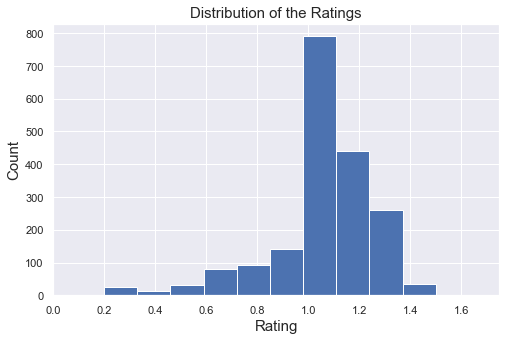

In [114]:
df.rating.plot(kind='hist', xlim=[0,1.75], figsize=(8,5))
plt.title('Distribution of the Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)


The mean dog rating is 1.06 and the ratings are more frequent between 1 and 1.3.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Count')

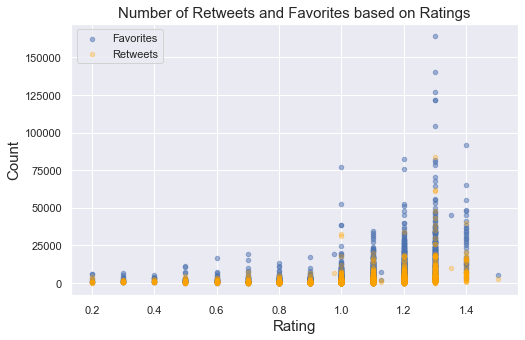

In [115]:
ax = df.plot.scatter(x='rating', y='favorite_count', alpha=0.5, label='Favorites');
df.plot.scatter(x='rating', y='retweet_count', color='Orange', alpha=0.3, label='Retweets', ax=ax, figsize=(8,5));
plt.title('Number of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)


<ipython-input-116-7e46eb227325>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('rating')['retweet_count','favorite_count'].mean().plot(kind='bar', figsize=(8,5))


Text(0, 0.5, 'Count')

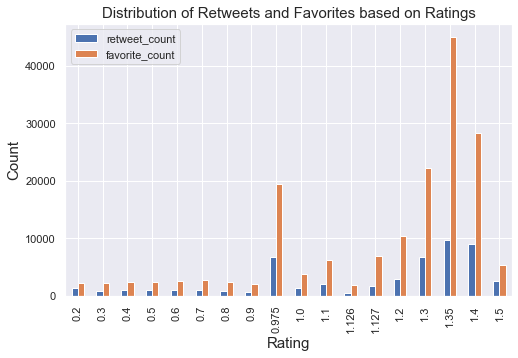

In [116]:
df.groupby('rating')['retweet_count','favorite_count'].mean().plot(kind='bar', figsize=(8,5))
plt.title('Distribution of Retweets and Favorites based on Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)

- The favorite counts are higher than the retweet counts for each rating
- The dogs with the ratings between 1.3 and 1.4 are retweeted and liked most.


It seems like there is a positive correlation between retweet counts and favorite counts based on ratings.

In [117]:
df[['rating','retweet_count','favorite_count']].corr(method = 'pearson')


,rating,retweet_count,favorite_count
rating,1.000000,0.306295,0.406224
retweet_count,0.306295,1.000000,0.930268
favorite_count,0.406224,0.930268,1.000000


Pearson correlation coefficients show that there is indeed a positive correlation between retweet counts and favorite counts. Surprisingly there is no correlation between ratings and retweet counts, as well as ratings and   favorite counts. One possible reason is that those ratings are given by only one account holder WeRateDogs and they are quite subjective. It is normal other people to like or retweet the tweets independent from their ratings but considering the pictures. Another reason might be the harmony between the picture and the tweet, if the text or the image are considered funny by the followers it might get higher number of likes and retweets even if it has a low rating. 




In [118]:
df.breed.value_counts()[:25]

None                         289
Golden Retriever             153
Labrador Retriever           102
Pembroke                     92 
Chihuahua                    90 
Pug                          59 
Toy Poodle                   51 
Chow                         44 
Pomeranian                   42 
Samoyed                      38 
Malamute                     32 
Cocker Spaniel               29 
Chesapeake Bay Retriever     29 
French Bulldog               28 
Miniature Pinscher           24 
Eskimo Dog                   22 
Staffordshire Bullterrier    21 
Siberian Husky               20 
Shih-tzu                     20 
Beagle                       20 
German Shepherd              20 
Shetland Sheepdog            19 
Cardigan                     19 
Rottweiler                   19 
Maltese Dog                  19 
Name: breed, dtype: int64

Take the dog breeds which are tweeted more than 20 times and exclude the category 'None'.

Text(0.5, 0, 'Breed')

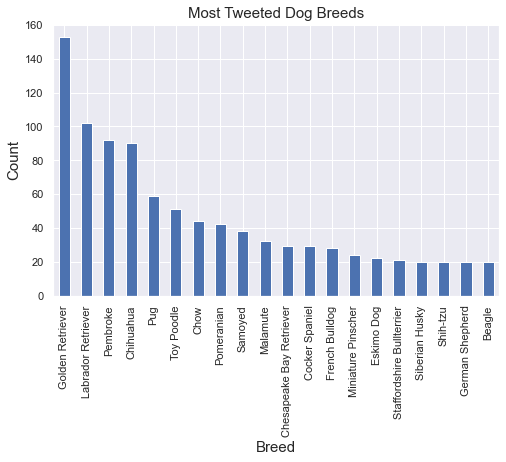

In [119]:
hot_breeds=df.groupby('breed').filter(lambda x: 200 > len(x) > 19)
hot_breeds['breed'].value_counts().plot(kind = 'bar', figsize=(8,5))
plt.title('Most Tweeted Dog Breeds', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Breed', fontsize=15)

Most tweeted dog breeds in order: Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, Pug. Golden Retriever is substantially higher.

Text(0, 0.5, 'Average Rating')

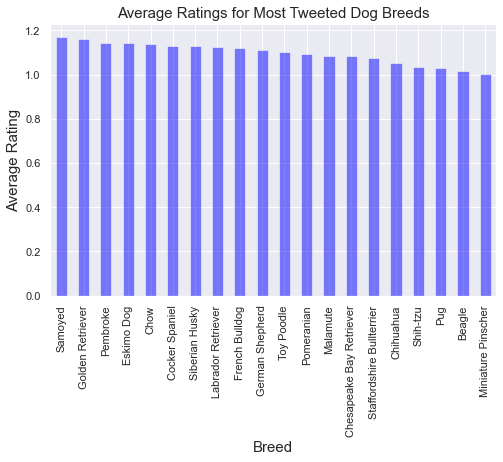

In [120]:
hot_breeds.groupby('breed')['rating'].mean().sort_values(ascending=False).plot(kind ='bar', color = 'Blue', alpha=0.5,figsize=(8,5))
plt.title('Average Ratings for Most Tweeted Dog Breeds', fontsize=15)
plt.xlabel('Breed', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)


Most tweeted dog breeds with the highest rating in order: Samoyed, Golden Retriever, Pembroke, Eskimo Dog, Chow

Text(0, 0.5, 'Average favorite counts')

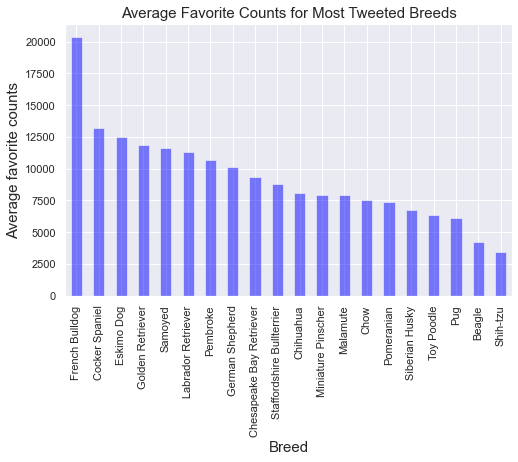

In [121]:
hot_breeds.groupby('breed')['favorite_count'].mean().sort_values(ascending=False).plot(kind ='bar', color = 'Blue', alpha=0.5, figsize=(8,5))
plt.title('Average Favorite Counts for Most Tweeted Breeds', fontsize=15)
plt.xlabel('Breed', fontsize=15)
plt.ylabel('Average favorite counts', fontsize=15)


Most tweeted dog breeds with the highest number of likes: French Bulldog, Cocker Spaniel, Eskimo Dog, Golden Retriever, Samoyed.

Most liked breeds differ from the breeds with highest ratings. Samoyed, Golden Retriever, and Eskimo Dog are common in the both lists.

In [122]:
df.dog_stage.value_counts()

None      1566
pupper    223 
doggo     70  
puppo     28  
floof     21  
Name: dog_stage, dtype: int64

Text(0.5, 0, 'Dog Stage')

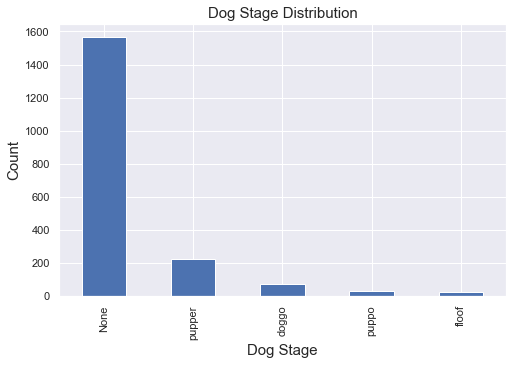

In [123]:
df.dog_stage.value_counts().plot(kind = 'bar', figsize=(8,5))
plt.title('Dog Stage Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)

There are 1566 dogs with unknown dog stage. It is a very high number and more time should be spent on cleaning dog_stage part. For now, I will exclude  the category 'None' and continue to analyze it.

Text(0.5, 0, 'Dog Stage')

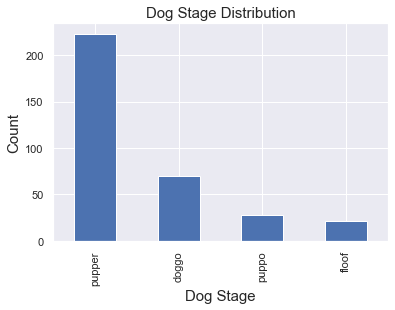

In [124]:
dog_stages=df.groupby('dog_stage').filter(lambda x: len(x) < 250)
dog_stages['dog_stage'].value_counts().plot(kind = 'bar')
plt.title('Dog Stage Distribution', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)

Most of the dogs are pupper.

Text(0, 0.5, 'Avarage Rating')

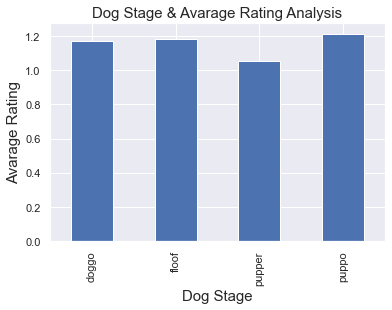

In [125]:
dog_stages.groupby('dog_stage')['rating'].mean().plot(kind='bar')
plt.title('Dog Stage & Avarage Rating Analysis', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)
plt.ylabel('Avarage Rating', fontsize=15)

The highest average rating is owned by puppos. Since it is an account for fun, it makes sense all of them have similar  and good ratings.

Text(0, 0.5, 'Avarage Favorite Count')

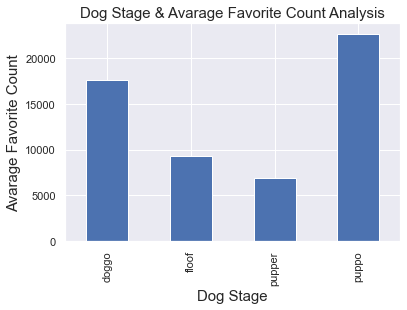

In [126]:
dog_stages.groupby('dog_stage')['favorite_count'].mean().plot(kind='bar')
plt.title('Dog Stage & Avarage Favorite Count Analysis', fontsize=15)
plt.xlabel('Dog Stage', fontsize=15)
plt.ylabel('Avarage Favorite Count', fontsize=15)


- The puppos has the highest favorite counts.
- Although, the puppers are more tweeted about, they have the lowest rating and favorite counts. 
- As I stated before it is not surprising to have such differences between ratings and like counts because the ratings are given by a unique account holder WeRateDogs in a subjective way.


#### Concluding Remarks

- The ratings, retweets and favorites are not only related with the dog images or videos, the humor of the account holder also affects the followers’ decisions.
- Image prediction algorithm is not always successful to detect the dog breed. Sometimes it detects another object in the picture rather than the dog, like a bagel.
- I believe I did a good job in re-extracting, cleaning and correcting names and ratings but dog stages needs much more work rather than extraction. Most of the dogs, their stages are not stated in the tweets.
- Some tweets rate other things rather than dogs, I cleaned a significant amount of data but it was not that easy to clean all of them, that is why there are still very low ratings.
